In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## Read and preprocess data

In [2]:
data = pd.read_csv('boston_house_prices.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
perc_missing = data.isnull().mean()*100
cols = perc_missing[perc_missing < 10].index.tolist() 
cols

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'PRICE']

In [4]:
data_final = data.fillna(-1)

In [5]:
train, val = train, val = train_test_split(data_final, test_size=0.2, random_state=11)

x_train = train.drop(columns=['PRICE'])
y_train = train['PRICE'].values

x_val = val.drop(columns=['PRICE'])
y_val = val['PRICE'].values

In [6]:
train_mae_values, val_mae_values = {}, {}

## Build individual models for comparison

In [7]:
# Decision Tree

dt_params = {
    'criterion': 'mae',
    'min_samples_leaf': 15,
    'random_state': 11
}

dt = DecisionTreeRegressor(**dt_params)

dt.fit(x_train, y_train)
dt_preds_train = dt.predict(x_train)
dt_preds_val = dt.predict(x_val)

train_mae_values['dt'] = mean_absolute_error(y_true=y_train, y_pred=dt_preds_train)
val_mae_values['dt'] = mean_absolute_error(y_true=y_val, y_pred=dt_preds_val)

In [8]:
# k-Nearest Neighbours

knn_params = {
    'n_neighbors': 5
}

knn = KNeighborsRegressor(**knn_params)

knn.fit(x_train, y_train)
knn_preds_train = knn.predict(x_train)
knn_preds_val = knn.predict(x_val)

train_mae_values['knn'] = mean_absolute_error(y_true=y_train, y_pred=knn_preds_train)
val_mae_values['knn'] = mean_absolute_error(y_true=y_val, y_pred=knn_preds_val)

In [9]:
# Random Forest

rf_params = {
    'n_estimators': 20,
    'criterion': 'mae',
    'max_features': 'sqrt',
    'min_samples_leaf': 10,
    'random_state': 11,
    'n_jobs': -1
}

rf = RandomForestRegressor(**rf_params)

rf.fit(x_train, y_train)
rf_preds_train = rf.predict(x_train)
rf_preds_val = rf.predict(x_val)

train_mae_values['rf'] = mean_absolute_error(y_true=y_train, y_pred=rf_preds_train)
val_mae_values['rf'] = mean_absolute_error(y_true=y_val, y_pred=rf_preds_val)

In [10]:
# Gradient Boosting

gbr_params = {
    'n_estimators': 20,
    'criterion': 'mae',
    'max_features': 'sqrt',
    'max_depth': 3,
    'min_samples_leaf': 10,
    'random_state': 11
}

gbr = GradientBoostingRegressor(**gbr_params)

gbr.fit(x_train, y_train)
gbr_preds_train = gbr.predict(x_train)
gbr_preds_val = gbr.predict(x_val)

train_mae_values['gbr'] = mean_absolute_error(y_true=y_train, y_pred=gbr_preds_train)
val_mae_values['gbr'] = mean_absolute_error(y_true=y_val, y_pred=gbr_preds_val)

## Stacked model

In [11]:
num_base_predictors = len(train_mae_values) # 4

x_train_with_metapreds = np.zeros((x_train.shape[0], x_train.shape[1]+num_base_predictors))
x_train_with_metapreds[:, :-num_base_predictors] = x_train
x_train_with_metapreds[:, -num_base_predictors:] = -1

In [12]:
kf = KFold(n_splits=5, random_state=11)

for train_indices, val_indices in kf.split(x_train):
    kfold_x_train, kfold_x_val = x_train.iloc[train_indices], x_train.iloc[val_indices]
    kfold_y_train, kfold_y_val = y_train[train_indices], y_train[val_indices]
    
    predictions = []
    
    dt = DecisionTreeRegressor(**dt_params)
    dt.fit(kfold_x_train, kfold_y_train)
    predictions.append(dt.predict(kfold_x_val))

    knn = KNeighborsRegressor(**knn_params)
    knn.fit(kfold_x_train, kfold_y_train)
    predictions.append(knn.predict(kfold_x_val))

    gbr = GradientBoostingRegressor(**gbr_params)
    rf.fit(kfold_x_train, kfold_y_train)
    predictions.append(rf.predict(kfold_x_val))

    gbr = GradientBoostingRegressor(**gbr_params)
    gbr.fit(kfold_x_train, kfold_y_train)
    predictions.append(gbr.predict(kfold_x_val))
    
    for i, preds in enumerate(predictions):
        x_train_with_metapreds[val_indices, -(i+1)] = preds

In [13]:
x_val_with_metapreds = np.zeros((x_val.shape[0], x_val.shape[1]+num_base_predictors))
x_val_with_metapreds[:, :-num_base_predictors] = x_val
x_val_with_metapreds[:, -num_base_predictors:] = -1

In [14]:
predictions = []
    
dt = DecisionTreeRegressor(**dt_params)
dt.fit(x_train, y_train)
predictions.append(dt.predict(x_val))

knn = KNeighborsRegressor(**knn_params)
knn.fit(x_train, y_train)
predictions.append(knn.predict(x_val))

gbr = GradientBoostingRegressor(**gbr_params)
rf.fit(x_train, y_train)
predictions.append(rf.predict(x_val))

gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(x_train, y_train)
predictions.append(gbr.predict(x_val))

for i, preds in enumerate(predictions):
    x_val_with_metapreds[:, -(i+1)] = preds

In [15]:
lr = LinearRegression(normalize=True)
lr.fit(x_train_with_metapreds, y_train)
lr_preds_train = lr.predict(x_train_with_metapreds)
lr_preds_val = lr.predict(x_val_with_metapreds)

train_mae_values['lr'] = mean_absolute_error(y_true=y_train, y_pred=lr_preds_train)
val_mae_values['lr'] = mean_absolute_error(y_true=y_val, y_pred=lr_preds_val)

## Visualising errors

In [16]:
mae_scores = pd.concat([pd.Series(train_mae_values, name='train'), 
                        pd.Series(val_mae_values, name='val')], 
                       axis=1)
mae_scores

,train,val
dt,2.384406,3.282353
knn,3.455545,3.978039
rf,2.316120,3.029828
gbr,2.463436,3.058634
lr,2.248086,2.850166


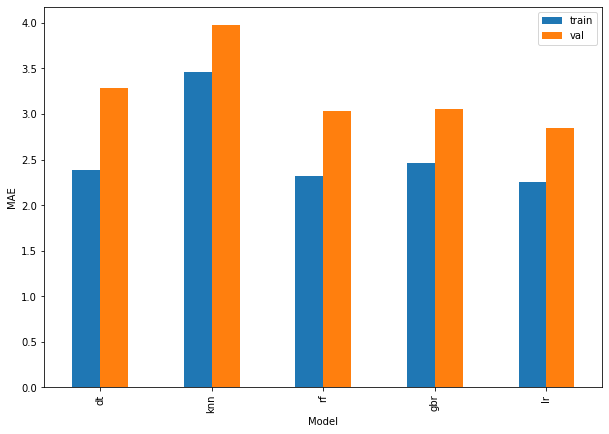

In [17]:
mae_scores.plot(kind='bar', figsize=(10,7))
plt.ylabel('MAE')
plt.xlabel('Model')
plt.show()

### Optionally, save the linear regression stacking model

In [18]:
import pickle
with open('../Saved Models/stacked_linear_regression.pkl', 'wb') as f:
    pickle.dump(lr, f)

### Also optionally, save the boston house prices regression dataset

In [19]:
df_house_prices_regression = pd.DataFrame(x_val_with_metapreds)
df_house_prices_regression['y'] = y_val

In [20]:
df_house_prices_regression.to_csv('./boston_house_prices_regression.csv', index=False)